In [1]:
%%time
%load_ext autoreload

from analysis_utils import *
from joblib import Parallel, delayed
import multiprocessing  
import numpy as np
import pandas as pd

#Growth rate = 3.0
#Computes the translation latencies from our model with simulations containing
#1 to 14 cognate ternary complexes in the voxel (14 to 42 not included because
#the probability of voxels with that number of cognates is ~0)
path = "./data/"
ensmbl_latency_dict = dict()
rxndiff=dict()
scalingFactor = 200
NR_scaledrates = {'k1r':718*200/scalingFactor,'k2f':1475*200/scalingFactor,'k2r_nr':1120*200/scalingFactor,'k3_nr':6*200/scalingFactor,'k4':209*200/scalingFactor}


data = "191003_2210/"
for i in range(1,7):
    sim_i = computeTransportRxnTimes(path+data,100*(i-1),100*(i-1)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))

data = "191105_0908/"
for i in range(7,14):
    sim_i = computeTransportRxnTimes(path+data, 100*(i-1-6),100*(i-1-6)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))
    
#Experimentally obtained codon usage frequencies and tRNA abundances at growth rate = 2.5 dbl/hr
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)

Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
CPU times: user 11.3 s, sys: 1.12 s, total: 12.4 s
Wall time: 15.4 s


In [2]:
def perturb(ptRNA,tRNA,tRNA_sorted, pCodon,ensmbl_latency_dict,pos,delta):
    ptRNA_maxval = max(gr25_ptRNA)
    ptRNA_minval = min(gr25_ptRNA)
    ptRNA_dict = dict(zip(tRNA, ptRNA))
    tRNA_1 = tRNA_sorted[pos]
    tRNA_0 = tRNA_sorted[pos-1]
    
    if pos==0:
        raise ValueError("pos cannot be zero")
        print("error")
        
    if  0.524*(ptRNA_dict[tRNA_0]+ptRNA_dict[tRNA_1]) > ptRNA_maxval:
        ptRNA_dict[tRNA_1] = ptRNA_dict[tRNA_1] - (ptRNA_maxval-ptRNA_dict[tRNA_0])
        ptRNA_dict[tRNA_0] = ptRNA_maxval
        
    elif 0.476*(ptRNA_dict[tRNA_0]+ptRNA_dict[tRNA_1]) < ptRNA_minval:
        ptRNA_dict[tRNA_0] = ptRNA_dict[tRNA_0] + (ptRNA_dict[tRNA_1]-ptRNA_minval)
        ptRNA_dict[tRNA_1] = ptRNA_minval
        
    else: 
        tot = (ptRNA_dict[tRNA_0]+ptRNA_dict[tRNA_1])
        ptRNA_dict[tRNA_1] = 0.476*tot
        ptRNA_dict[tRNA_0] = 0.524*tot
    
    arr = []
    if sum(ptRNA_dict.values())>1.0000001:
        print("Total over 1.0: ", sum(ptRNA_dict.values()))
        
    for i in range(30):
        arr.append(computeElongationLatency(np.array(list(ptRNA_dict.values())), pCodon, ensmbl_latency_dict)[0][0])
    return np.average(arr), np.array(list(ptRNA_dict.values()))
def monotonicity(ptRNA):
    if (len(ptRNA)==40):
        return (sum(np.diff(ptRNA) <= 0)/40)*100
    else:
        raise ValueError("Length of ptRNA is not 40")
        print("Length of ptRNA is not 40")

Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
Unique transcripts without a Gene identifier:  272
Sequences not available for # genes in Ecocyc DB:  153
Inconsistency in codons:  0
3767
Missing genes in transcriptome_dict in compute_transcript_distributions:  133
all genes
[0.08123126194614116, 0.08212342743873052, 0.06195066441529554, 0.07604461446545532, 0.06350475084318546, 0.007913772176334247, 0.06471351776549156, 0.06655037765235057, 0.04952850970474256, 0.05497887400245486, 0.06307145063537409, 0.02317693012385308, 0.03933746737121183, 0.03854534429979515, 0.06005172928076274, 0.04017355604670932, 0.0039223168867047005, 0.021893414067457383, 0.007387337329405662, 0.0038714046481972755

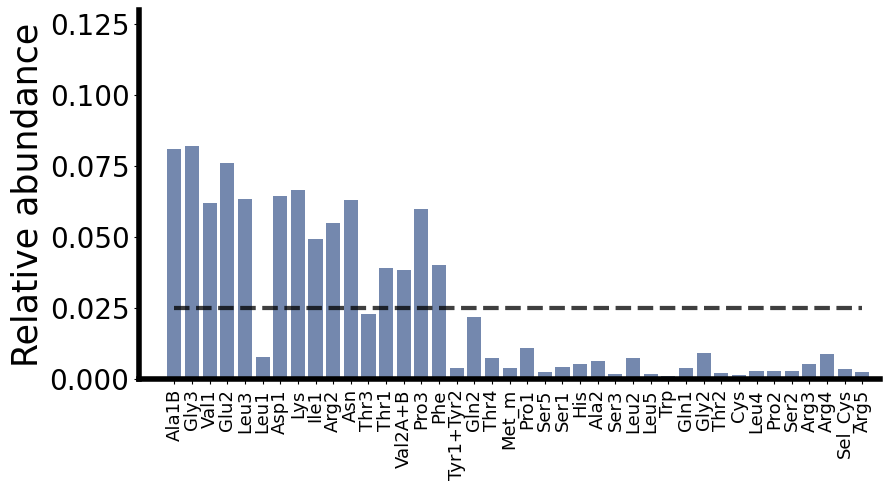

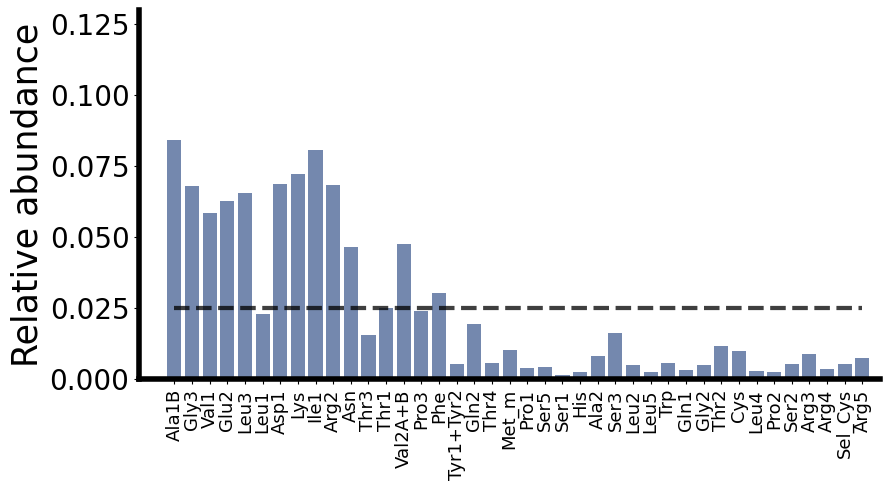

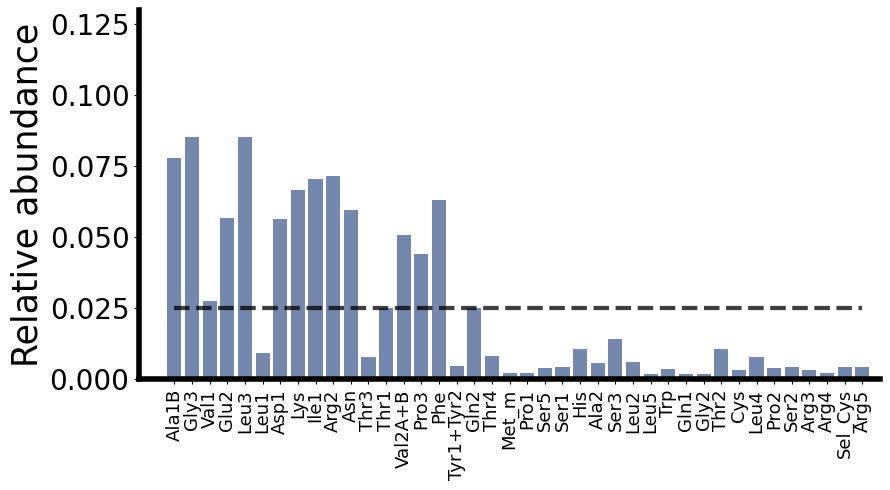

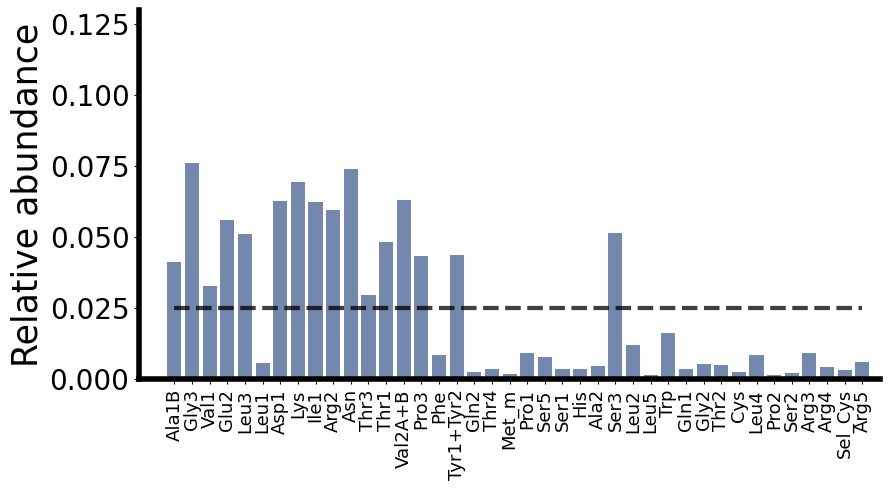

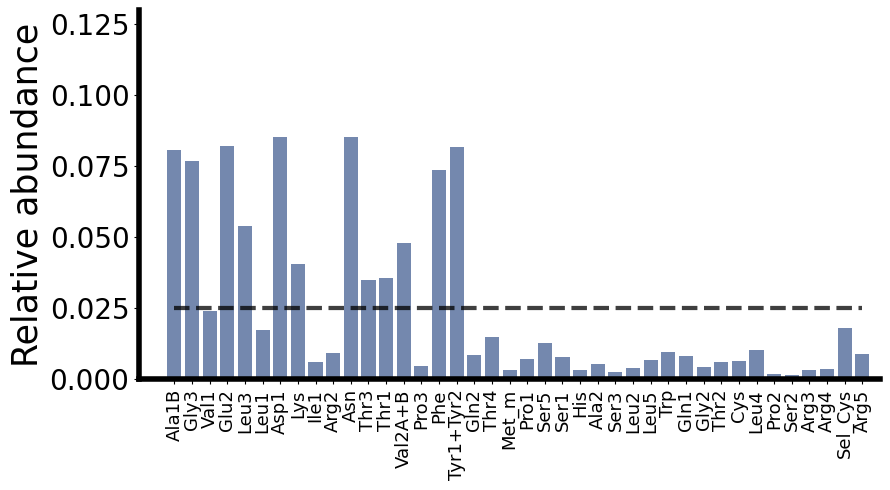

In [2]:
#All genes no stratification

tRNA_tags = ["Ala1B", "Ala2", "Arg2", "Arg3", "Arg4", "Arg5", "Asn", "Asp1", "Cys", "Gln1", "Gln2", \
"Glu2", "Gly2", "Gly3", "His", "Ile1", "Leu1", "Leu2", "Leu3", "Leu4", "Leu5", "Lys", \
"Met_m", "Phe", "Pro1", "Pro2", "Pro3", "Sel_Cys", "Ser1", "Ser2", "Ser3", "Ser5", "Thr1", \
"Thr2", "Thr3", "Thr4", "Trp", "Tyr1+Tyr2", "Val1", "Val2A+B"]
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']

#Load elongation rate per codon
codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map,gene_latency = compute_gene_elongt(codon_elongt)
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map,gene_latency)
pCodon_WT = np.array(pCodon_transcriptome)

ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(gr25_ptRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

#Sort tRNA by codon usage in transcriptome and plot baseline tRNA frequency
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]

#Resort ptRNA_min and plot
print("all genes")

ptRNA_list_fast=np.load('./data/UniformRandomtRNA_WTCodonUsage_2ksample_fasttRNA_ptRNA.npy')
elongt_list_fast =np.load('./data/UniformRandomtRNA_WTCodonUsage_2ksample_fasttRNA_elongt.npy')

ptRNA_min = ptRNA_list_fast[np.argmin(elongt_list_fast)]
ptRNA_min_dict = dict(zip(tRNA_tags,ptRNA_min))
ptRNA_min_sorted=[ptRNA_min_dict[tRNA] for tRNA in tRNA_sorted]
fig,ax = plt.subplots(figsize=(9,5))
ax.bar(np.arange(40),ptRNA_min_sorted,color='#39568CFF',width=0.8,alpha=0.7)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,40)
ax.set_ylabel('Relative abundance',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=13)
ax.set_ylim(0,0.13)

plt.tight_layout()
print(ptRNA_min_sorted)
fig.savefig('./Figures/S11a.svg', dpi=300,bbox_inches='tight')


####### HIGH ######
print("stratify high")
#Load data
ptRNA_list_fast_high=np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifyhigh_2ksample_fasttRNA_ptRNA2.npy')
elongt_list_fast_high =np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifyhigh_2ksample_fasttRNA_elongt2.npy')

#ptRNA_list_fast_low=np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifylow_2ksample_fasttRNA_ptRNA.npy')
#elongt_list_fast_low =np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifylow_2ksample_fasttRNA_elongt.npy')


#Analysis
ptRNA_min_high = ptRNA_list_fast_high[np.argmin(elongt_list_fast_high)]
ptRNA_min_high_dict = dict(zip(tRNA_tags,ptRNA_min_high))
ptRNA_min_high_sorted=[ptRNA_min_high_dict[tRNA] for tRNA in tRNA_sorted]

#ptRNA_min_low = ptRNA_list_fast_low[np.argmin(elongt_list_fast_low)]
#ptRNA_min_low_dict = dict(zip(tRNA_tags,ptRNA_min_low))
#ptRNA_min_low_sorted=[ptRNA_min_low_dict[tRNA] for tRNA in tRNA_sorted]

#Plotting
fig,ax = plt.subplots(figsize=(9,5))
ax.bar(np.arange(40),ptRNA_min_high_sorted,color='#39568CFF',width=0.8,alpha=0.7)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,40)
ax.set_ylabel('Relative abundance',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=13)
ax.set_ylim(0,0.13)

plt.tight_layout()
fig.savefig('./Figures/S11b-right.svg', dpi=300,bbox_inches='tight')



###### MIDDLE ######
print("stratify middle")


#Load data
ptRNA_list_fast_middle=np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifymiddle_2ksample_fasttRNA_ptRNA.npy')
elongt_list_fast_middle =np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifymiddle_2ksample_fasttRNA_elongt.npy')


#Analysis
ptRNA_min_middle = ptRNA_list_fast_middle[np.argmin(elongt_list_fast_middle)]
ptRNA_min_middle_dict = dict(zip(tRNA_tags,ptRNA_min_middle))
ptRNA_min_middle_sorted=[ptRNA_min_middle_dict[tRNA] for tRNA in tRNA_sorted]

#Plotting
fig,ax = plt.subplots(figsize=(9,5))
ax.bar(np.arange(40),ptRNA_min_middle_sorted,color='#39568CFF',width=0.8,alpha=0.7)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,40)
ax.set_ylabel('Relative abundance',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=13)
ax.set_ylim(0,0.13)

plt.tight_layout()
fig.savefig('./Figures/S11c-right.svg', dpi=300,bbox_inches='tight')


##### LOW ######
print("stratify low")

#Load data
ptRNA_list_fast_low=np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifylow_2ksample_fasttRNA_ptRNA2.npy')
elongt_list_fast_low =np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifylow_2ksample_fasttRNA_elongt2.npy')

#Analysis
ptRNA_min_low = ptRNA_list_fast_low[np.argmin(elongt_list_fast_low)]
ptRNA_min_low_dict = dict(zip(tRNA_tags,ptRNA_min_low))
ptRNA_min_low_sorted=[ptRNA_min_low_dict[tRNA] for tRNA in tRNA_sorted]

#Plotting
fig,ax = plt.subplots(figsize=(9,5))
ax.bar(np.arange(40),ptRNA_min_low_sorted,color='#39568CFF',width=0.8,alpha=0.7)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,40)
ax.set_ylabel('Relative abundance',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=13)
ax.set_ylim(0,0.13)

plt.tight_layout()
fig.savefig('./Figures/S11d-right.svg', dpi=300,bbox_inches='tight')


###### HIGHEST ######
print("stratify highest")


#Load data
ptRNA_list_fast_highest=np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifyhighest_2ksample_fasttRNA_ptRNA.npy')
elongt_list_fast_highest =np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifyhighest_2ksample_fasttRNA_elongt.npy')


#Analysis
ptRNA_min_highest = ptRNA_list_fast_highest[np.argmin(elongt_list_fast_highest)]
ptRNA_min_highest_dict = dict(zip(tRNA_tags,ptRNA_min_highest))
ptRNA_min_highest_sorted=[ptRNA_min_highest_dict[tRNA] for tRNA in tRNA_sorted]

#Plotting
fig,ax = plt.subplots(figsize=(9,5))
ax.bar(np.arange(40),ptRNA_min_highest_sorted,color='#39568CFF',width=0.8,alpha=0.7)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,40)
ax.set_ylabel('Relative abundance',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=13)
ax.set_ylim(0,0.13)

plt.tight_layout()
fig.savefig('./Figures/S12a.svg', dpi=300,bbox_inches='tight')

Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
high
Unique transcripts without a Gene identifier:  0
Sequences not available for # genes in Ecocyc DB:  1
Inconsistency in codons:  0
419
Missing genes in transcriptome_dict in compute_transcript_distributions:  3135


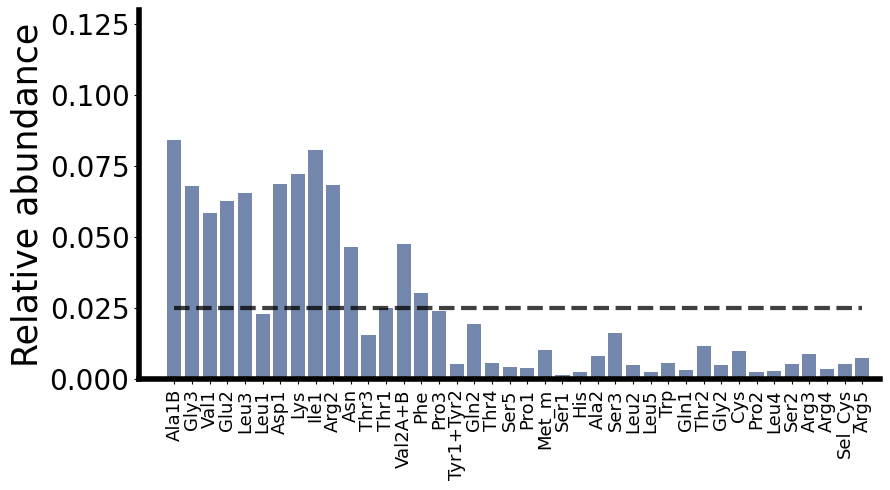

In [3]:
#High expression stratification figure

#Load elongation rate per codon
codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map,gene_latency = compute_gene_elongt(codon_elongt, stratify='high')
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map,gene_latency)
pCodon_WT = np.array(pCodon_transcriptome)

ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(gr25_ptRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

#Sort tRNA by codon usage in transcriptome and plot baseline tRNA frequency
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]

#Load data
ptRNA_list_fast_high=np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifyhigh_2ksample_fasttRNA_ptRNA2.npy')
elongt_list_fast_high =np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifyhigh_2ksample_fasttRNA_elongt2.npy')

#ptRNA_list_fast_low=np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifylow_2ksample_fasttRNA_ptRNA.npy')
#elongt_list_fast_low =np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifylow_2ksample_fasttRNA_elongt.npy')


#Analysis
ptRNA_min_high = ptRNA_list_fast_high[np.argmin(elongt_list_fast_high)]
ptRNA_min_high_dict = dict(zip(tRNA_tags,ptRNA_min_high))
ptRNA_min_high_sorted=[ptRNA_min_high_dict[tRNA] for tRNA in tRNA_sorted]

#ptRNA_min_low = ptRNA_list_fast_low[np.argmin(elongt_list_fast_low)]
#ptRNA_min_low_dict = dict(zip(tRNA_tags,ptRNA_min_low))
#ptRNA_min_low_sorted=[ptRNA_min_low_dict[tRNA] for tRNA in tRNA_sorted]

#Plotting
fig,ax = plt.subplots(figsize=(9,5))
ax.bar(np.arange(40),ptRNA_min_high_sorted,color='#39568CFF',width=0.8,alpha=0.7)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,40)
ax.set_ylabel('Relative abundance',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=13)
ax.set_ylim(0,0.13)

plt.tight_layout()
fig.savefig('./Figures/S11b-left.svg', dpi=300,bbox_inches='tight')


Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
middle
Unique transcripts without a Gene identifier:  185
Sequences not available for # genes in Ecocyc DB:  138
Inconsistency in codons:  0
3035
Missing genes in transcriptome_dict in compute_transcript_distributions:  550


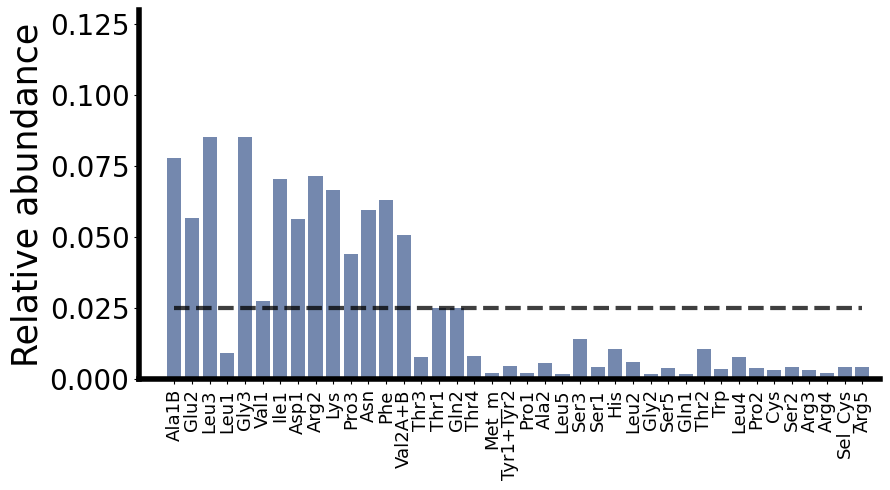

In [4]:
#Middle expression stratification

#Load elongation rate per codon
codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map,gene_latency = compute_gene_elongt(codon_elongt, stratify='middle')
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map,gene_latency)
pCodon_WT = np.array(pCodon_transcriptome)

ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(gr25_ptRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

#Sort tRNA by codon usage in transcriptome and plot baseline tRNA frequency
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]

#Load data
ptRNA_list_fast_middle=np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifymiddle_2ksample_fasttRNA_ptRNA.npy')
elongt_list_fast_middle =np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifymiddle_2ksample_fasttRNA_elongt.npy')


#Analysis
ptRNA_min_middle = ptRNA_list_fast_middle[np.argmin(elongt_list_fast_middle)]
ptRNA_min_middle_dict = dict(zip(tRNA_tags,ptRNA_min_middle))
ptRNA_min_middle_sorted=[ptRNA_min_middle_dict[tRNA] for tRNA in tRNA_sorted]

#Plotting
fig,ax = plt.subplots(figsize=(9,5))
ax.bar(np.arange(40),ptRNA_min_middle_sorted,color='#39568CFF',width=0.8,alpha=0.7)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,40)
ax.set_ylabel('Relative abundance',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=13)
ax.set_ylim(0,0.13)

plt.tight_layout()
fig.savefig('./Figures/S11c-left.svg', dpi=300,bbox_inches='tight')


Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
low
Unique transcripts without a Gene identifier:  87
Sequences not available for # genes in Ecocyc DB:  15
Inconsistency in codons:  0
319
Missing genes in transcriptome_dict in compute_transcript_distributions:  3552


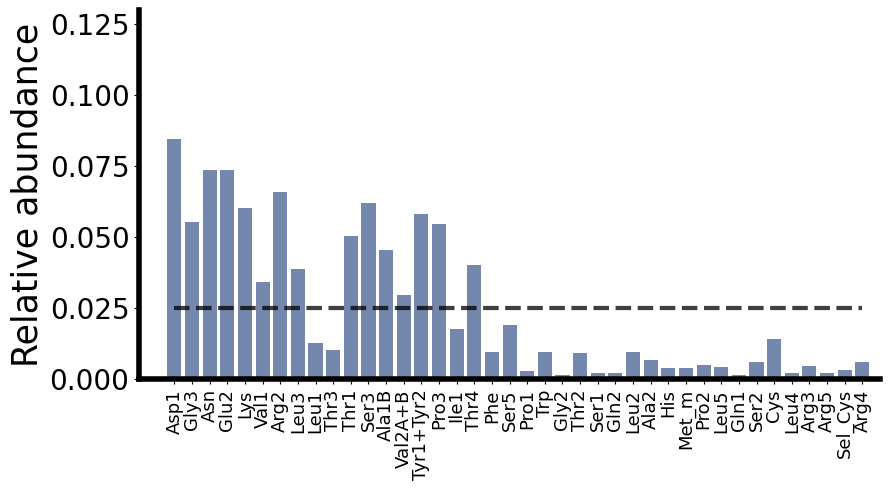

In [5]:
#Low expression stratification

#Load elongation rate per codon
codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map,gene_latency = compute_gene_elongt(codon_elongt, stratify='low')
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map,gene_latency)
pCodon_WT = np.array(pCodon_transcriptome)

ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(gr25_ptRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

#Sort tRNA by codon usage in transcriptome and plot baseline tRNA frequency
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]

#Load data
ptRNA_list_fast_low=np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifylow_2ksample_fasttRNA_ptRNA.npy')
elongt_list_fast_low =np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifylow_2ksample_fasttRNA_elongt.npy')

#Analysis
ptRNA_min_low = ptRNA_list_fast_low[np.argmin(elongt_list_fast_low)]
ptRNA_min_low_dict = dict(zip(tRNA_tags,ptRNA_min_low))
ptRNA_min_low_sorted=[ptRNA_min_low_dict[tRNA] for tRNA in tRNA_sorted]

#Plotting
fig,ax = plt.subplots(figsize=(9,5))
ax.bar(np.arange(40),ptRNA_min_low_sorted,color='#39568CFF',width=0.8,alpha=0.7)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,40)
ax.set_ylabel('Relative abundance',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=13)
ax.set_ylim(0,0.13)

plt.tight_layout()
fig.savefig('./Figures/S11d-left.svg', dpi=300,bbox_inches='tight')



(0.0, 0.1)

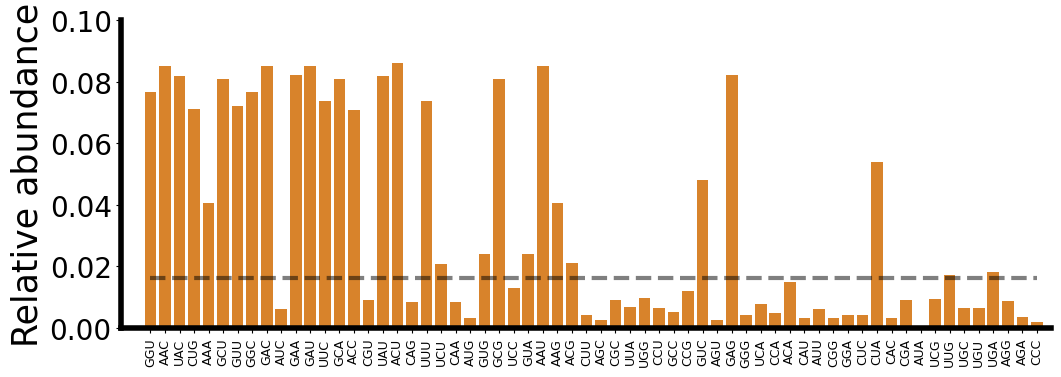

In [48]:
ptRNA_byCodon_dict = {}
for codon in codon_sorted:
    ptRNA_byCodon_dict[codon] = (sum([ptRNA_min_highest_dict[codon_i] for codon_i in codon_dict[codon]]))
ptRNA_byCodon = np.array(list(ptRNA_byCodon_dict.values()))

#Plot codon frequency sorted by decreasing frequency
fig,ax = plt.subplots(figsize=(12,4))
ax.bar(np.arange(62),ptRNA_byCodon,color='#d8832b',width=0.8)
ax.plot(np.arange(62),[1/62]*62,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax.set_xlim(-2,62)
ax.set_ylabel('Relative abundance',fontsize=25)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=9)
ax.set_ylim(0,0.10)



In [ ]:
ptRNA_dict['Asn']

Number of polypeptides reported:  4434
Returned gene map of length  15934
Removed  24  non-divisible by three genes
['insAB1', 'insCD2', 'dgd', 'insCD4', 'insCD6', 'alaB', 'prfB', 'supK', 'b2891', 'ECK2886', 'insCD3', 'insEF4', 'insAB2', 'insEF5', 'insCD1', 'insAB5', 'insEF1', 'insCD5', 'insEF3', 'insAB3', 'insJK', 'insAB4', 'insEF2', 'insAB6']
Unique transcripts without a Gene identifier:  0
Sequences not available for # genes in Ecocyc DB:  0
Inconsistency in codons:  0
1
Missing genes in transcriptome_dict in compute_transcript_distributions:  3553


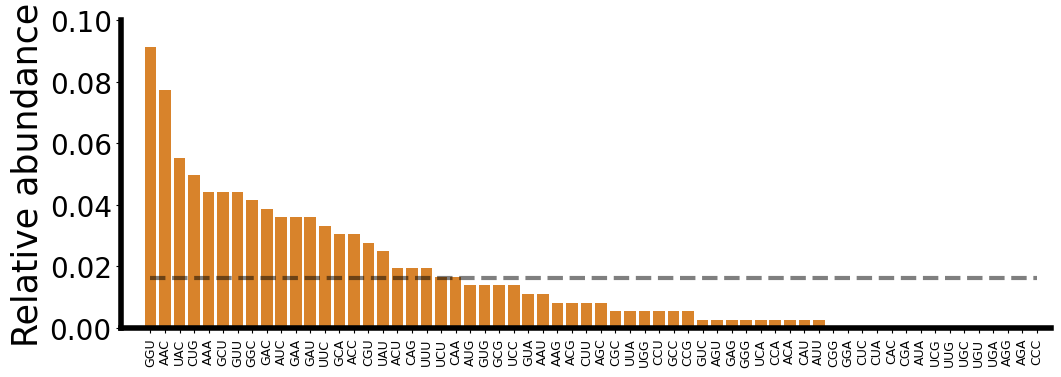

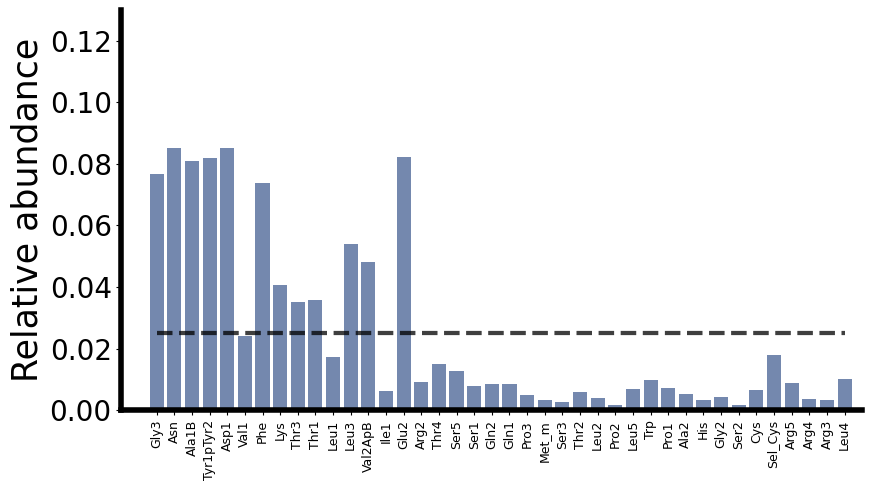

In [47]:
#Highest gene expression stratification
tRNA_tags = ["Ala1B", "Ala2", "Arg2", "Arg3", "Arg4", "Arg5", "Asn", "Asp1", "Cys", "Gln1", "Gln2", \
"Glu2", "Gly2", "Gly3", "His", "Ile1", "Leu1", "Leu2", "Leu3", "Leu4", "Leu5", "Lys", \
"Met_m", "Phe", "Pro1", "Pro2", "Pro3", "Sel_Cys", "Ser1", "Ser2", "Ser3", "Ser5", "Thr1", \
"Thr2", "Thr3", "Thr4", "Trp", "Tyr1pTyr2", "Val1", "Val2ApB"]
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']

#Load elongation rate per codon
codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
gene_map,gene_latency = compute_gene_elongt(codon_elongt, stratify='highest')
pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map,gene_latency)
pCodon_WT = np.array(pCodon_transcriptome)

ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(gr25_ptRNA,pCodon_transcriptome,extra2=True)
codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]

#Plot codon frequency sorted by decreasing frequency
fig,ax = plt.subplots(figsize=(12,4))
ax.bar(np.arange(62),pCodon_sorted,color='#d8832b',width=0.8)
ax.plot(np.arange(62),[1/62]*62,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax.set_xlim(-2,62)
ax.set_ylabel('Relative abundance',fontsize=25)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=9)
ax.set_ylim(0,0.10)


#Sort tRNA by codon usage in transcriptome and plot baseline tRNA frequency
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]

#Load data
ptRNA_list_fast_highest=np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifyhighest_2ksample_fasttRNA_ptRNA.npy')
elongt_list_fast_highest =np.load('./data/UniformRandomtRNA_WTCodonUsage_stratifyhighest_2ksample_fasttRNA_elongt.npy')


#Analysis
ptRNA_min_highest = ptRNA_list_fast_highest[np.argmin(elongt_list_fast_highest)]
ptRNA_min_highest_dict = dict(zip(tRNA_tags,ptRNA_min_highest))
ptRNA_min_highest_sorted=[ptRNA_min_highest_dict[tRNA] for tRNA in tRNA_sorted]

#Plotting
fig,ax = plt.subplots(figsize=(9,5))
ax.bar(np.arange(40),ptRNA_min_highest_sorted,color='#39568CFF',width=0.8,alpha=0.7)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
ax.plot(np.arange(40),[1/40]*40,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(tRNA_tags)), tRNA_sorted,rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,40)
ax.set_ylabel('Relative abundance',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=9)
ax.set_ylim(0,0.13)

plt.tight_layout()